In [2]:
#######################################################################################################################################
## GES: Greenhouse Energy Simulation

# This python3 code simulates heat, mass and CO$_2$ exchange in an unheated, ventilated single-zone greenhouse for a simple test case. 
# The heat transfer processes simulated include convection, conduction and radiation, together with plant transpiration for simulation
# of heat and mass exchange due to evaporation of water from the leaf surface. 
# Simple models of photosynthesis and crop growth for tomatoes are included in order to simulate CO_2 exchange. 
# The model is based on the GDGCM (Pieters, J. and Deltour, J., 'The Gembloux Dynamic Greenhouse Climate Model - GDGCM', 2000) 
# and on the thesis by Vanthoor (Vanthoor, B.H.,'A model-based greenhouse design method', PhD Thesis, Wageningen University, 2011).

# The original code was written in MATLAB and can be found on GitHub at https://github.com/EECi/GES.

# The files required include:

# functions.py
#   contains generic functions for convection, radiation and conduction calculations, climate data interpolation and calculation of 
#   relative humidity
# parameters.py
#   contains parameter values for fundamental constants, greenhouse construction and operation and plant geometry and growth.
# SampleWeather.csv
#   Hourly input weather data, in the format 'Hour, Ambient Temperature ($^o$C), Sky Temperature ($^o$C), Windspeed (m/s), 
#   Relative Humidity (%), Direct Solar Radiation (order NE wall, NE Roof, SE Wall, SE Roof, SW Wall, SW Roof, NW Wall, NW Roof) 
#   (W/m$^2$), Diffuse Solar Radiation (order as for Direct)(W/m$^2$)

#######################################################################################################################################

## Initialise

import numpy as np

from model.model import model
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import time

from model.parameters import *

## Specify initial conditions**

# Temperatures
T_c_0 = 20. + T_k # Cover temperature [K]
T_i_0 = 12. + T_k # Internal air temperature [K]
T_v_0 = 12. + T_k # Vegetation temperature [K]
T_m_0 = 12. + T_k # Growing medium temperature [K]
T_p_0 = 12. + T_k # Tray temperature [K]
T_f_0 = 12. + T_k # Floor temperature [K]
T_s1_0 = 12. + T_k # Temperature of soil layer 1 [K]
T_s2_0 = 12. + T_k # Temperature of soil layer 2 [K]
T_s3_0 = 12. + T_k # Temperature of soil layer 3 [K]
T_s4_0 = 11. + T_k # Temperature of soil layer 4 [K]
#
T_vmean_0 = 12. + T_k; # 24 hour mean vegetation temperature [K]


# =============================================================================
T_vsum_0 = 0; # Vegetation temperature sum [degC]                       
#
C_w_0 = 0.0085 # Density of water vapour [kg/m^3]
C_c_0 = 7.5869e-4 # CO_2 density
#                     
C_buf_0 = 0.01 # Mass of carbohydrate in buffer per unit per unit area of cultivated floor [kg/m^2]
C_fruit_0 = 0.001 # Mass of carbohydrate in fruit per unit per unit area of cultivated floor [kg/m^2]
C_leaf_0 = 0.01 # Mass of carbohydrate in leaves per unit per unit area of cultivated floor [kg/m^2]
C_stem_0 = 0.01 # Mass of carbohydrate in stem per unit per unit area of cultivated floor [kg/m^2]
R_fruit_0 = 0. # Relative growth rate of fruit averaged over 5 days [1/s]
R_leaf_0 = 0. # Relative growth rate of leaf averaged over 5 days [1/s]
R_stem_0 = 0. # Relative growth rate of stem averaged over 5 days [1/s]

z = [T_c_0, T_i_0, T_m_0, T_p_0, T_f_0, T_s1_0, T_s2_0, T_s3_0, T_s4_0, 
     C_w_0, C_c_0,T_v_0, T_vmean_0,T_vsum_0,C_buf_0, C_fruit_0, C_leaf_0, C_stem_0, R_fruit_0, R_leaf_0, R_stem_0]

daynum = [0]

## Interpolate weather data

climdat = np.genfromtxt('SampleWeather.csv', delimiter=',') # Hourly data

l=len(climdat)
mult=np.linspace(1,l,int((l-1)*3600/deltaT))
y_interp = interp1d(climdat[:,0], climdat[:,1:21],axis=0)

climate = y_interp(mult)

## Simulate over time

tic = time.time()

sim_days = 10 # Number of days of simulation
tf = 86400*sim_days # Time in seconds
t = [0,tf]
tval = np.linspace(0,tf,tf+1)

# Use solve_ivp with 'BDF' stiff solver to solve the ODEs
params = [climate, daynum]

output = solve_ivp(model, t, z, method='BDF', t_eval=tval, rtol = 1e-5, args=params)

# Time simulation and print time taken
toc = time.time()

xt = toc-tic

print('Runtime(s) = ', f"{xt:.3}")

#######################################################################################################################################
## Plot results

print('Plotting results ...')

Tout_c = np.transpose(output.y[0,:]-T_k)
Tout_i = np.transpose(output.y[1,:]-T_k)
Tout_m = np.transpose(output.y[2,:]-T_k)
Tout_p = np.transpose(output.y[3,:]-T_k)
Tout_f = np.transpose(output.y[4,:]-T_k)
Tout_s1 = np.transpose(output.y[5,:]-T_k)
Tout_s2 = np.transpose(output.y[6,:]-T_k)
Tout_s3 = np.transpose(output.y[7,:]-T_k)
Tout_s4 = np.transpose(output.y[8,:]-T_k)


Cwout = np.transpose(output.y[9,:])
Ccout = np.transpose(output.y[10,:])

Tout_v = np.transpose(output.y[11,:]-T_k)

Tvmeanout = np.transpose(output.y[12,:])

Tvsumout = np.transpose(output.y[13,:])


C_buf = np.transpose(output.y[14,:])
C_fruit = np.transpose(output.y[15,:])
C_leaf = np.transpose(output.y[16,:])
C_stem = np.transpose(output.y[17,:])

Rfruitout = np.transpose(output.y[18,:])
Rleafout = np.transpose(output.y[19,:])
Rstemout = np.transpose(output.y[20,:])

#Temperatures

time = output.t/(3600*24) # Time in days
resolution_value = 1200




/home/djoroya/Documents/Greenhouse/model/ComputeFluxes.py:180: RuntimeWarning: invalid value encountered in scalar divide
  P = J*(C_stom - Gamma)/(4*(C_stom + 2*Gamma)) # Photosynthesis rate [mol{CO2}/s]


ValueError: cannot convert float NaN to integer

In [2]:
import pandas  as pd


In [3]:
df_original = pd.read_csv('output_original.csv')

In [4]:
df_original.shape

(3001, 22)

In [5]:
df = pd.DataFrame(data={"Time (days)": time, "Cover Temperature (C)": Tout_c, "Internal Air Temperature (C)": Tout_i,
                            "Vegetation Temperature (C)": Tout_v, "Growing Medium Temperature (C)": Tout_m, 
                            "Tray Temperature (C)": Tout_p, "Floor Temperature (C)": Tout_f, "Soil Layer 1 Temperature (C)": Tout_s1,
                            "Soil Layer 2 Temperature (C)": Tout_s2, "Soil Layer 3 Temperature (C)": Tout_s3, 
                            "Soil Layer 4 Temperature (C)": Tout_s4, "Vegetation Mean Temperature (C)": Tvmeanout, 
                            "Vegetation Temperature Sum (C)": Tvsumout, "Water Vapour Density (kg/m^3)": Cwout, 
                            "CO2 Density (kg/m^3)": Ccout, "Carbohydrate in Buffer (kg/m^2)": C_buf, 
                            "Carbohydrate in Fruit (kg/m^2)": C_fruit, "Carbohydrate in Leaf (kg/m^2)": C_leaf, 
                            "Carbohydrate in Stem (kg/m^2)": C_stem, "Relative Growth Rate of Fruit (1/s)": Rfruitout, 
                            "Relative Growth Rate of Leaf (1/s)": Rleafout, "Relative Growth Rate of Stem (1/s)": Rstemout})

In [6]:
# compare df_original with df

np_original = df_original.to_numpy()
np_df = df.loc[:3000].to_numpy()

diff = np.abs(np_original - np_df)**2

error = np.sum(diff)

print('Error = ', error)

if error < 1e-4:
    print('Test Passed')
else:
    raise ValueError('Test Failed')

Error =  3.122174470841039e-22
Test Passed


In [7]:

from matplotlib import pyplot as plt



Text(0, 0.5, 'Temperature ($^o$C)')

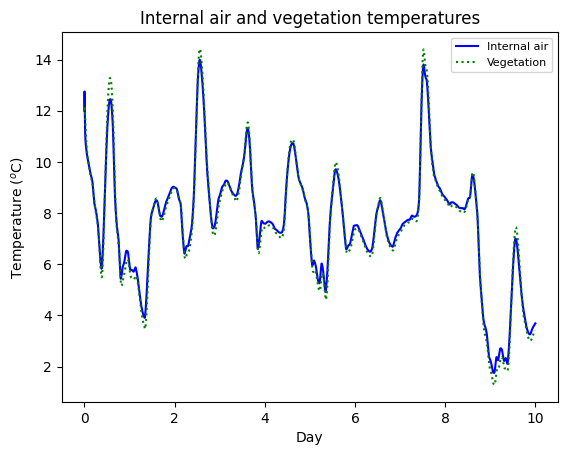

In [8]:

# Internal air, vegetation

fig1, ax = plt.subplots()

ax.plot(time,Tout_i, color='b', label = 'Internal air')
ax.plot(time,Tout_v, color='g', linestyle = ':', label = 'Vegetation')
ax.set_title('Internal air and vegetation temperatures')
ax.legend(loc='upper right', fontsize=8)

ax.set_xlabel('Day')
ax.set_ylabel('Temperature ($^o$C)')



Text(0, 0.5, 'Temperature ($^o$C)')

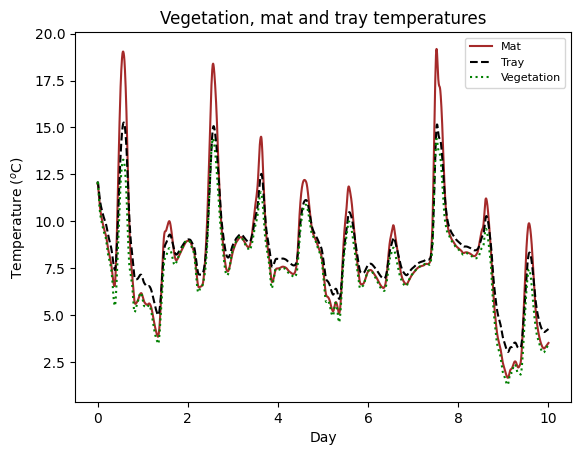

In [9]:

# Mat, tray, vegetation

fig2, ax2 = plt.subplots()

ax2.plot(time,Tout_m, color='brown', linestyle = '-', label = 'Mat')
ax2.plot(time,Tout_p, color='k', linestyle = '--', label = 'Tray')
ax2.plot(time,Tout_v, color='g', linestyle = ':', label = 'Vegetation')


ax2.set_title('Vegetation, mat and tray temperatures')
ax2.legend(loc='upper right', fontsize=8)

ax2.set_xlabel('Day')
ax2.set_ylabel('Temperature ($^o$C)')



Text(0, 0.5, 'Temperature ($^o$C)')

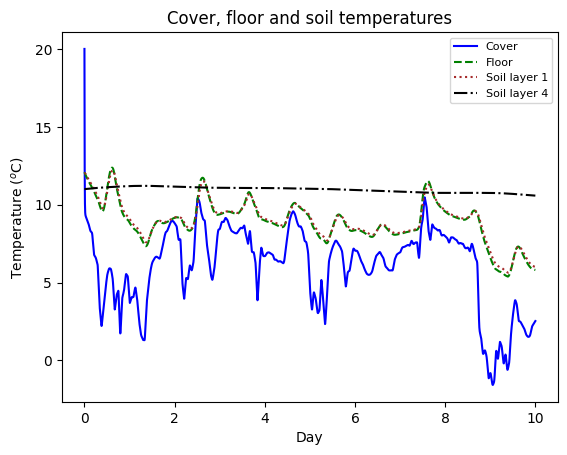

In [10]:

# Cover, floor, Soil layer 1, soil layer 4

fig3, ax1 = plt.subplots()

ax1.plot(time,Tout_c, color='b', label = 'Cover')
ax1.plot(time,Tout_f, color='g', linestyle = '--', label = 'Floor')
ax1.plot(time,Tout_s1, color='brown', linestyle = ':', label = 'Soil layer 1')
ax1.plot(time,Tout_s4,color='k',linestyle='-.', label = 'Soil layer 4')

ax1.set_title('Cover, floor and soil temperatures')
ax1.legend(loc='upper right', fontsize=8)

ax1.set_xlabel('Day')
ax1.set_ylabel('Temperature ($^o$C)')



Text(0, 0.5, 'LAI')

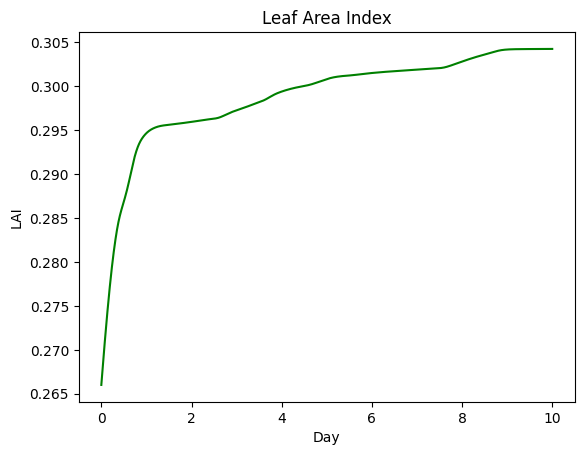

In [11]:

# LAI

fig4, ax3 = plt.subplots()

LAI = C_leaf * SLA

ax3.plot(time,LAI, color='g')
ax3.set_title('Leaf Area Index')
ax3.set_xlabel('Day')
ax3.set_ylabel('LAI')



Text(0, 0.5, 'Relativce Humidity (%)')

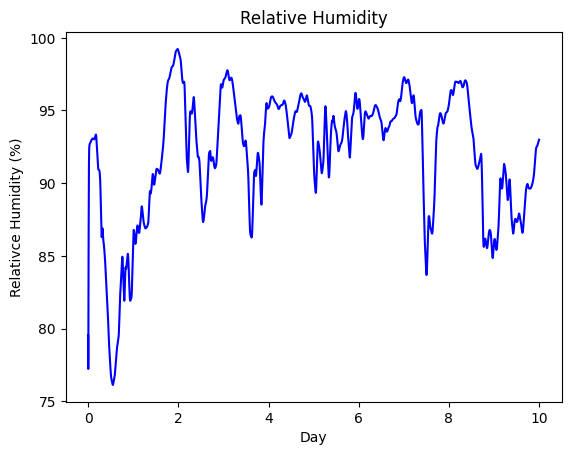

In [12]:

# Relative Humidity
from model.tools.functions import sat_conc

RHout = 100*Cwout/sat_conc(Tout_i+T_k)

fig5, ax5 = plt.subplots()
ax5.plot(time,RHout, color='b')
ax5.set_title('Relative Humidity')
ax5.set_xlabel('Day')
ax5.set_ylabel('Relativce Humidity (%)')



Text(0, 0.5, 'CO$_2$ (ppm)')

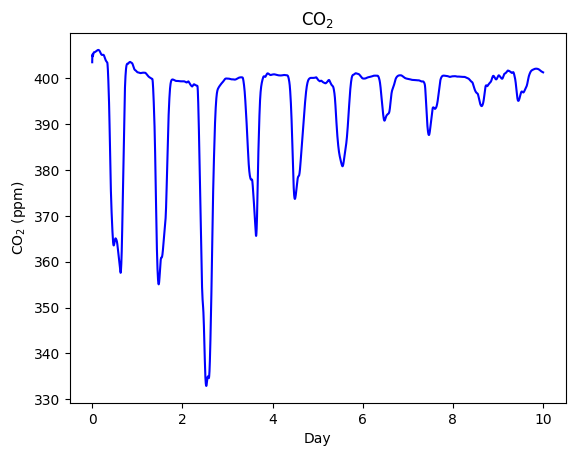

In [13]:

# CO_2

Ccout_ppm = Ccout*R*(Tout_i+T_k)/(M_c*atm)*1.e6

fig6, ax4 = plt.subplots()
ax4.plot(time,Ccout_ppm, color='b')
ax4.set_title('CO$_2$')
ax4.set_xlabel('Day')
ax4.set_ylabel('CO$_2$ (ppm)')


# Show plots before code completion

#plt.show()


